# Homework 4 - Craft Beer  

**Goal:** Predict the `abv` based on features provided in beers.csv and breweries.csv. Features such as `ibu` and `style` will likely have most impact on `abv`. 

In [5]:
import pandas as pd
import numpy as np
import warnings
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
import plotly.express as px
import plotly.offline as off
pd.options.plotting.backend = "plotly"
import matplotlib.pyplot as plt
# this line helps render plotly charts inside jupyter notebooks if they're not running
off.init_notebook_mode()
# this is to silent warning messages
warnings.filterwarnings("ignore")

## Load and prep datasets
- Load beers.csv and breweries.csv
- Review and modify datesets as needed.

In [6]:
# Import two datasets
df_beer = pd.read_csv("https://raw.githubusercontent.com/mhcode001/GA_HW4/main/data/beers.csv")
df_brewery = pd.read_csv("https://raw.githubusercontent.com/mhcode001/GA_HW4/main/data/breweries.csv")
# Review beer dataset
df_beer.head(5)

Unnamed: 0    abv  ibu    id                 name  \
0           0  0.050  NaN  1436             Pub Beer   
1           1  0.066  NaN  2265          Devil's Cup   
2           2  0.071  NaN  2264  Rise of the Phoenix   
3           3  0.090  NaN  2263             Sinister   
4           4  0.075  NaN  2262        Sex and Candy   

                            style  brewery_id  ounces  
0             American Pale Lager         408    12.0  
1         American Pale Ale (APA)         177    12.0  
2                    American IPA         177    12.0  
3  American Double / Imperial IPA         177    12.0  
4                    American IPA         177    12.0

In [7]:
# Review brewery dataset
df_brewery.head(5)

Unnamed: 0                       name           city state
0           0         NorthGate Brewing     Minneapolis    MN
1           1  Against the Grain Brewery     Louisville    KY
2           2   Jack's Abby Craft Lagers     Framingham    MA
3           3  Mike Hess Brewing Company      San Diego    CA
4           4    Fort Point Beer Company  San Francisco    CA

In [8]:
df_beer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2410 non-null   int64  
 1   abv         2348 non-null   float64
 2   ibu         1405 non-null   float64
 3   id          2410 non-null   int64  
 4   name        2410 non-null   object 
 5   style       2405 non-null   object 
 6   brewery_id  2410 non-null   int64  
 7   ounces      2410 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 150.8+ KB


In [9]:
df_beer.nunique()

Unnamed: 0    2410
abv             74
ibu            107
id            2410
name          2305
style           99
brewery_id     558
ounces           7
dtype: int64

In [10]:
df_brewery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  558 non-null    int64 
 1   name        558 non-null    object
 2   city        558 non-null    object
 3   state       558 non-null    object
dtypes: int64(1), object(3)
memory usage: 17.6+ KB


In [11]:
# Make name colunm in both dataframes to be more descriptive 
df_beer.rename(columns = {'name':'beer_name'}, inplace = True)
df_brewery.rename(columns = {'name':'brewery_name'}, inplace = True)

In [12]:
# Check for nulls in beer
df_beer.isnull().sum()

Unnamed: 0       0
abv             62
ibu           1005
id               0
beer_name        0
style            5
brewery_id       0
ounces           0
dtype: int64

In [13]:
# Check for nulls in brewery
df_brewery.isnull().sum()

Unnamed: 0      0
brewery_name    0
city            0
state           0
dtype: int64

In [14]:
# Query for rows (indexes) where abv and ibu contain nulls
both_null = df_beer[ (df_beer['abv'].isnull()) & (df_beer['ibu'].isnull())].index
both_null

Int64Index([ 294,  299,  315,  316,  317,  318,  407,  408,  450,  451,  464,
             520,  521,  522,  523,  541,  566,  655,  656,  723,  728,  729,
             730,  731,  732,  733,  734,  812,  836,  924, 1030, 1117, 1132,
            1167, 1168, 1169, 1170, 1171, 1172, 1173, 1353, 1554, 1555, 1556,
            1558, 1636, 1667, 1668, 1714, 1719, 1760, 1813, 1887, 1969, 2044,
            2051, 2163, 2186, 2337, 2345, 2347, 2349],
           dtype='int64')

In [15]:
# Drop nulls from above cell
df_beer.drop(both_null, inplace = True)

In [16]:
# Note abv has none (from 62), ibv has 943 (from 1005), style has 2 (from 3)
df_beer.isnull().sum()

Unnamed: 0      0
abv             0
ibu           943
id              0
beer_name       0
style           2
brewery_id      0
ounces          0
dtype: int64

In [17]:
df_beer.describe()

Unnamed: 0          abv          ibu           id   brewery_id  \
count  2348.000000  2348.000000  1405.000000  2348.000000  2348.000000   
mean   1206.639693     0.059773    42.713167  1439.355196   230.250426   
std     697.327731     0.013542    25.954066   748.647386   156.191601   
min       0.000000     0.001000     4.000000     1.000000     0.000000   
25%     603.750000     0.050000    21.000000   827.750000    93.000000   
50%    1213.500000     0.056000    35.000000  1463.500000   205.000000   
75%    1811.250000     0.067000    64.000000  2078.250000   365.000000   
max    2409.000000     0.128000   138.000000  2692.000000   557.000000   

            ounces  
count  2348.000000  
mean     13.591695  
std       2.332586  
min       8.400000  
25%      12.000000  
50%      12.000000  
75%      16.000000  
max      32.000000

In [18]:
# Review nulls in style
df_beer[df_beer['style'].isnull()]

Unnamed: 0    abv   ibu    id                       beer_name style  \
853         853  0.060  21.0  1635  Kilt Lifter Scottish-Style Ale   NaN   
866         866  0.053  27.0  2527                   OktoberFiesta   NaN   

     brewery_id  ounces  
853         160    12.0  
866          66    12.0

In [19]:
# Replace nulls in stype with N/A
df_beer['style'].fillna('NA', inplace = True)

In [20]:
df_beer.isnull().sum()

Unnamed: 0      0
abv             0
ibu           943
id              0
beer_name       0
style           0
brewery_id      0
ounces          0
dtype: int64

In [21]:
# Rows with nulls for ibu
ibu_null = df_beer.loc[df_beer['ibu'].isnull()]
ibu_null

Unnamed: 0    abv  ibu    id                    beer_name  \
0              0  0.050  NaN  1436                     Pub Beer   
1              1  0.066  NaN  2265                  Devil's Cup   
2              2  0.071  NaN  2264          Rise of the Phoenix   
3              3  0.090  NaN  2263                     Sinister   
4              4  0.075  NaN  2262                Sex and Candy   
...          ...    ...  ...   ...                          ...   
2403        2403  0.055  NaN  1045          Wynkoop Pumpkin Ale   
2404        2404  0.075  NaN  1035  Rocky Mountain Oyster Stout   
2406        2406  0.052  NaN   807                Rail Yard Ale   
2407        2407  0.055  NaN   620              B3K Black Lager   
2409        2409  0.052  NaN    84         Rail Yard Ale (2009)   

                               style  brewery_id  ounces  
0                American Pale Lager         408    12.0  
1            American Pale Ale (APA)         177    12.0  
2                       American IPA         177    12.0  
3     American Double / Imperial IPA         177    12.0  
4                       American IPA         177    12.0  
...                              ...         ...     ...  
2403                     Pumpkin Ale         424    12.0  
2404                  American Stout         424    12.0  
2406        American Amber / Red Ale         424    12.0  
2407                     Schwarzbier         424    12.0  
2409        American Amber / Red Ale         424    12.0  

[943 rows x 8 columns]

In [22]:
# Review the ibu mean vs median
ibu_mean = df_beer['ibu'].mean()
ibu_median = df_beer['ibu'].median()
print(f"mean: {ibu_mean}")
print(f"median: {ibu_median}")

mean: 42.71316725978647
median: 35.0


In [23]:
# View the distribution of ibu
px.histogram(df_beer, x = 'ibu', height = 325, width = 600)

In [24]:
# Replace ibu nulls with ibu mean will not work as it places too much emphasis on ibu range = 42-43
# ibu_mean = df_beer['ibu'].fillna(df_beer['ibu'].mean())

# View the distribution of ibu after changing to ibu nulls mean
# px.histogram(ibu_mean, x = 'ibu', height = 325, width = 600)

In [25]:
# Get the mean ibu based on style to even out the dataset
df_beer.groupby('style')['ibu'].mean()

style
Abbey Single Ale              22.000000
Altbier                       34.125000
American Adjunct Lager        11.000000
American Amber / Red Ale      36.298701
American Amber / Red Lager    23.250000
                                ...    
Tripel                        23.500000
Vienna Lager                  24.357143
Wheat Ale                     24.000000
Winter Warmer                 24.625000
Witbier                       16.208333
Name: ibu, Length: 100, dtype: float64

In [26]:
#  Replace ibu null using mean of each brewery
df_beer['ibu'].fillna(df_beer.groupby('style')['ibu'].transform('mean'), inplace = True)

In [27]:
#  Now, there is a spike in ibu = 67.5 to 72.4
px.histogram(df_beer, x = 'ibu', height = 325, width = 600)

In [28]:
# Now, only 52 nulls in ibu
df_beer['ibu'].isnull().sum()

52

In [29]:
# Replace remaining 11 ibu nulls with ibu mean
df_beer['ibu'].fillna(df_beer['ibu'].mean(), inplace = True)

In [30]:
# Now it increases the ibu range from 37.5 to 42.4
px.histogram(df_beer, x = 'ibu', height = 325, width = 600)

In [31]:
# Now, there is 0 null in ibu
df_beer['ibu'].isnull().sum()

0

## Merge Dataframes
Merge `df_beer` and `df_brewery`

In [32]:
# Rename unnamed column to 'brewery_id'
df_brewery.rename(columns = {'Unnamed: 0':'brewery_id'}, inplace = True)

In [33]:
# Drop 'Unnamed: 0' column in dataframe
df_beer.drop('Unnamed: 0', axis=1, inplace=True)

In [34]:
# Join beer with brewery
df = pd.merge(df_beer, df_brewery, how = 'left', on='brewery_id')

In [35]:
df

abv        ibu    id             beer_name  \
0     0.050  26.750000  1436              Pub Beer   
1     0.066  44.941176  2265           Devil's Cup   
2     0.071  67.634551  2264   Rise of the Phoenix   
3     0.090  93.320000  2263              Sinister   
4     0.075  67.634551  2262         Sex and Candy   
...     ...        ...   ...                   ...   
2343  0.067  45.000000   928             Belgorado   
2344  0.052  36.298701   807         Rail Yard Ale   
2345  0.055  31.000000   620       B3K Black Lager   
2346  0.055  40.000000   145   Silverback Pale Ale   
2347  0.052  36.298701    84  Rail Yard Ale (2009)   

                               style  brewery_id  ounces  \
0                American Pale Lager         408    12.0   
1            American Pale Ale (APA)         177    12.0   
2                       American IPA         177    12.0   
3     American Double / Imperial IPA         177    12.0   
4                       American IPA         177    12.0   
...                              ...         ...     ...   
2343                     Belgian IPA         424    12.0   
2344        American Amber / Red Ale         424    12.0   
2345                     Schwarzbier         424    12.0   
2346         American Pale Ale (APA)         424    12.0   
2347        American Amber / Red Ale         424    12.0   

                   brewery_name    city state  
0     10 Barrel Brewing Company    Bend    OR  
1           18th Street Brewery    Gary    IN  
2           18th Street Brewery    Gary    IN  
3           18th Street Brewery    Gary    IN  
4           18th Street Brewery    Gary    IN  
...                         ...     ...   ...  
2343    Wynkoop Brewing Company  Denver    CO  
2344    Wynkoop Brewing Company  Denver    CO  
2345    Wynkoop Brewing Company  Denver    CO  
2346    Wynkoop Brewing Company  Denver    CO  
2347    Wynkoop Brewing Company  Denver    CO  

[2348 rows x 10 columns]

In [36]:
# Add city_state column to create more unique values as city are duplicated with different states. 
# This didn't should any improvements in score.
#df['city_state'] = df['city'] + df['state']
#df

In [37]:
#df.drop(['city', 'state'], axis = 1, inplace = True)

In [38]:
# Check for Duplicates in dataframe. None found.
df[df.duplicated(keep=False)]

Empty DataFrame
Columns: [abv, ibu, id, beer_name, style, brewery_id, ounces, brewery_name, city, state]
Index: []

# Data Visualization

In [39]:
# Top 10 cites with most brewery - Portland and Grand Rapids tied with 64 breweries
top_city = df.groupby('city')[['brewery_id']].count().sort_values(by=['brewery_id'], ascending = False).reset_index()
px.bar(top_city.head(10), x = 'city', y = 'brewery_id', color = 'brewery_id', title = 'Top 10 Citys with Most Brewery')

In [40]:
# Total # of brewery by State - Colorado has the most with 250 breweries
top_st = df.groupby('state')[['brewery_id']].count().reset_index()

px.bar(top_st.sort_values(by=['brewery_id'], ascending = False), 
       x= 'state', y = 'brewery_id', color = 'brewery_id', title = 'Total # of Brewery by States')

In [41]:
# Beer style by IBU 
# Higher IBU beer style also appear to have higher ABV - Higher bitterness has higher alcohol volume.
style_ibu = df.groupby('style')[['ibu', 'abv']].mean().sort_values(by=['ibu'],ascending = False).reset_index()
style_ibu.head(10)
px.bar(style_ibu, y = 'ibu', x = 'style', color = 'abv')

In [42]:
# Similarily, higher ABU with beer stype have higher IBU too.
style_abv = df.groupby('style')[['ibu', 'abv']].mean().sort_values(by=['abv'],ascending = False).reset_index()
style_abv.head(10)
px.bar(style_abv, y = 'abv', x = 'style', color = 'ibu')

In [43]:
# The 8.4 ounces have the highest ABV and IBU
oz = df.groupby('ounces')[['ibu', 'abv']].mean().reset_index()
oz
px.bar(oz, x = 'ounces', y = 'abv', color = 'ibu', facet_col = 'ounces', title = 'Ounces with IBU')

In [44]:
px.scatter(df, y = df['ibu'], x = df['abv'], trendline = 'lowess', color = 'ibu', title = 'ABV with IBU')

# Model Validation
### Used with GradientBoostingRegressor 

In [45]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
mod = GradientBoostingRegressor

# Create different modeling pipelines for each encoding technique
pipe1 = make_pipeline(ce.OrdinalEncoder(), mod(max_depth = 6))
pipe2 = make_pipeline(ce.OneHotEncoder(use_cat_names = True), mod(max_depth = 6))
pipe3 = make_pipeline(ce.TargetEncoder(), mod(max_depth = 6))

# Create a training and test set
X = df.drop('abv', axis = 1)
y = df['abv']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 80)

# Function for getting a validation score and split training set for validation set
def get_val_score(X, y, mod, val_size = 0.2, random_state = 8):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = val_size, random_state = random_state)
    mod.fit(X_train, y_train)
    return mod.score(X_val, y_val)

In [46]:
# Get validation scores for each of the encoding techniques
ordinal_score = get_val_score(X_train, y_train, pipe1)
onehot_score = get_val_score(X_train, y_train, pipe2)
target_score = get_val_score(X_train, y_train, pipe3)
print(f'Ordinal_Score: {ordinal_score}')
print(f'OneHot_Score:  {onehot_score}')
print(f'Target_Score:  {target_score}')

Ordinal_Score: 0.4129781597415062
OneHot_Score:  0.5160304622741338
Target_Score:  0.5281713164531818


**Since OneHot and Target are similar, I decided to use Target. Note: Using GradientBoostingRegressor appears to "boost" the scores by approx .10  
Style has the most importance.**

In [47]:
# feature importance to get an idea of what is driving results initially
feats = pd.DataFrame({
    'Columns': pipe3[0].transform(X_train).columns,
    'Importance': pipe3[1].feature_importances_
})

feats.sort_values(by = 'Importance', ascending = False)

Columns  Importance
3         style    0.627740
0           ibu    0.111717
6  brewery_name    0.096374
1            id    0.057527
7          city    0.033126
4    brewery_id    0.032500
8         state    0.022781
5        ounces    0.013495
2     beer_name    0.004740

In [48]:
get_val_score(X_train, y_train, pipe3)

0.5226084368038062

In [49]:
# Look at the log transformed scores for comparsion 
get_val_score(X_train, np.log(y_train), pipe3)

0.2597492083248012

In [51]:
# different values of model parameters to test out
max_depth = [6, 7, 8, 9, 10]
max_features = [0.25, 0.50, 0.75, 0.9]
min_samples_leaf = [5, 10, 15, 20, 25]
cv_scores = []

# go through and try different ones
for depth in max_depth:
    for feature in max_features:
        for sample in min_samples_leaf:
            print(f"Getting validation score for: depth: {depth}, max_features: {feature}, leaf_samples: {sample}")
            pipe3[-1].set_params(max_depth = depth, max_features = feature, min_samples_leaf = sample)
            # notice we are fitting on the log of the data
            val_score = get_val_score(X_train, np.log(y_train), pipe1)
            cv_scores.append((val_score, depth, feature, sample))

Getting validation score for: depth: 6, max_features: 0.25, leaf_samples: 5
Getting validation score for: depth: 6, max_features: 0.25, leaf_samples: 10
Getting validation score for: depth: 6, max_features: 0.25, leaf_samples: 15
Getting validation score for: depth: 6, max_features: 0.25, leaf_samples: 20
Getting validation score for: depth: 6, max_features: 0.25, leaf_samples: 25
Getting validation score for: depth: 6, max_features: 0.5, leaf_samples: 5
Getting validation score for: depth: 6, max_features: 0.5, leaf_samples: 10
Getting validation score for: depth: 6, max_features: 0.5, leaf_samples: 15
Getting validation score for: depth: 6, max_features: 0.5, leaf_samples: 20
Getting validation score for: depth: 6, max_features: 0.5, leaf_samples: 25
Getting validation score for: depth: 6, max_features: 0.75, leaf_samples: 5
Getting validation score for: depth: 6, max_features: 0.75, leaf_samples: 10
Getting validation score for: depth: 6, max_features: 0.75, leaf_samples: 15
Getting

In [52]:
# Look at what gave you the best results
max(cv_scores)

(0.2453003744669583, 7, 0.75, 5)

In [54]:
# Set the parameters that gave us the best validation score
pipe3[-1].set_params(max_depth = 7, max_features = .75, min_samples_leaf = 5)

# Test score
get_val_score(X, y, pipe3)

0.589794707060238

In [55]:
# Feature importance to get an idea of what is driving results 
feats = pd.DataFrame({
    'Columns': pipe3[0].transform(X_train).columns,
    'Importance': pipe3[1].feature_importances_
})

feats.sort_values(by = 'Importance', ascending = False)

Columns  Importance
3         style    0.569050
0           ibu    0.157007
6  brewery_name    0.106581
7          city    0.046315
1            id    0.040763
4    brewery_id    0.039315
8         state    0.019845
2     beer_name    0.011302
5        ounces    0.009822

## Model Inference

In [56]:
from pdpbox import pdp

### Partial Dependence Plot for Target Encoder¶

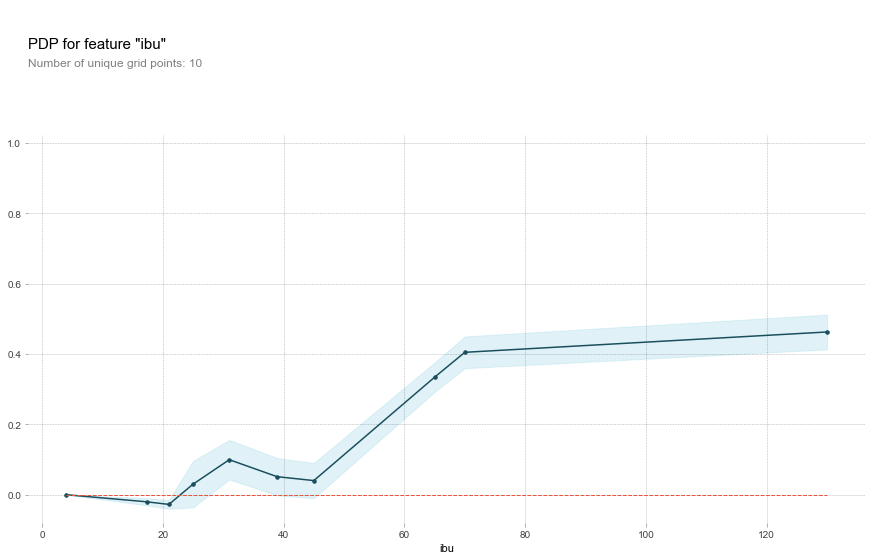

In [57]:
# Transform the dataset to use for this function
X_train_transformed = pipe3[0].transform(X_train)

# Store this because onehot encoding changes the number of columns in the dataset
X_train_cols = X_train_transformed.columns

pdp_style = pdp.pdp_isolate(
    # This is the model with the predictions
    model = pipe1[1], 
    
    # This is the final dataset THAT'S BEEN TRANSFORMED FOR THE MODEL
    # Using the training set since that is what our model was fit on
    dataset = pipe3[0].transform(X_train), 
    
    # Column names from the transformed training set
    model_features = X_train_cols, 
    
    # Column label
    feature = 'ibu',
)
# Formatting
fig, axes = pdp.pdp_plot(pdp_style, 'ibu')

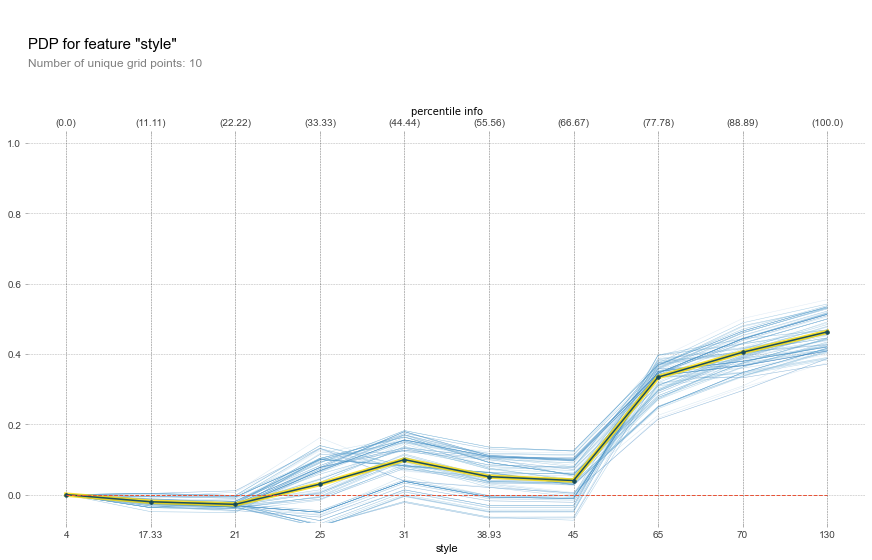

In [58]:
fig, axes = pdp.pdp_plot(
    pdp_style, 'style', plot_lines=True, frac_to_plot=100, x_quantile=True, 
 show_percentile=True
)

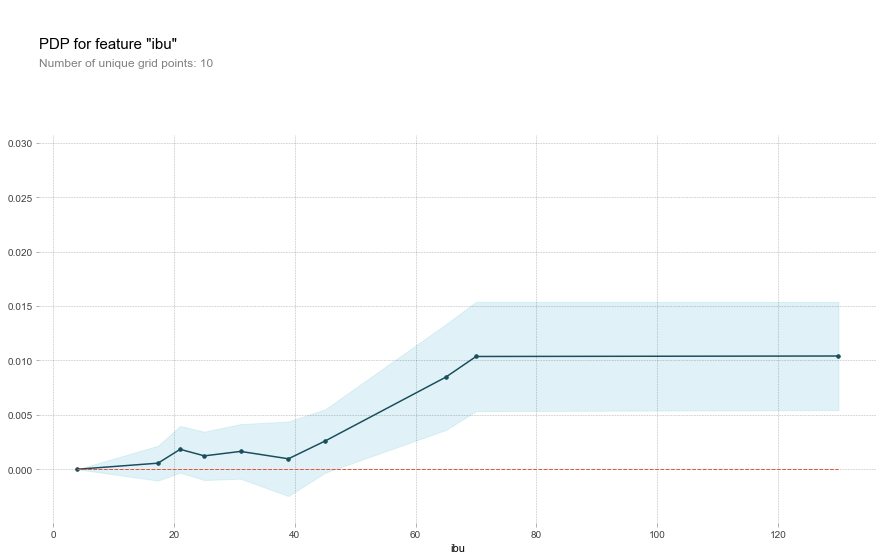

In [59]:
X_train_transformed = pipe3[0].transform(X_train)

X_train_cols = X_train_transformed.columns

pdp_ibu = pdp.pdp_isolate(
    model = pipe3[1], 
    dataset = pipe3[0].transform(X_train), 
    model_features = X_train_cols, 
    feature = 'ibu',
)

fig, axes = pdp.pdp_plot(pdp_ibu, 'ibu')

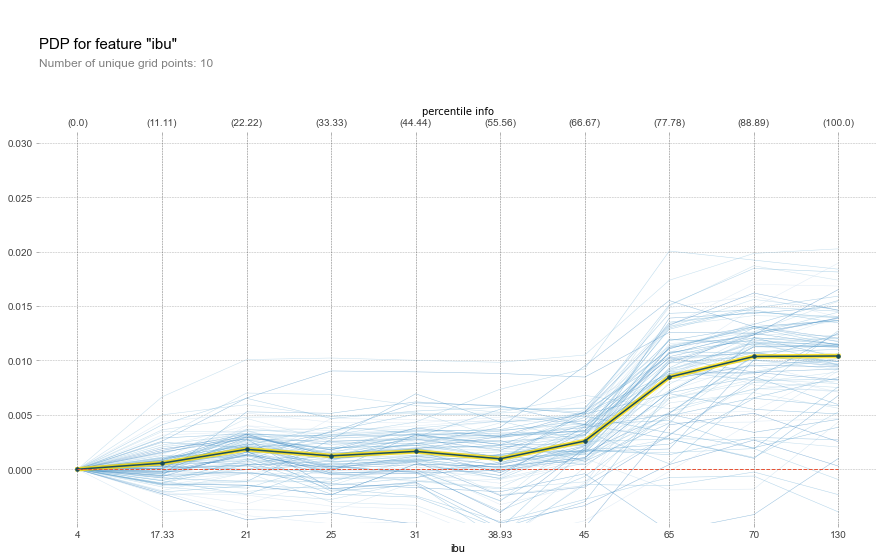

In [60]:
fig, axes = pdp.pdp_plot(
    pdp_ibu, 'ibu', plot_lines=True, frac_to_plot=100, x_quantile=True, 
 show_percentile=True
)

With Target Encoding is hard to see the style types, but higher IBU is tied to style types.

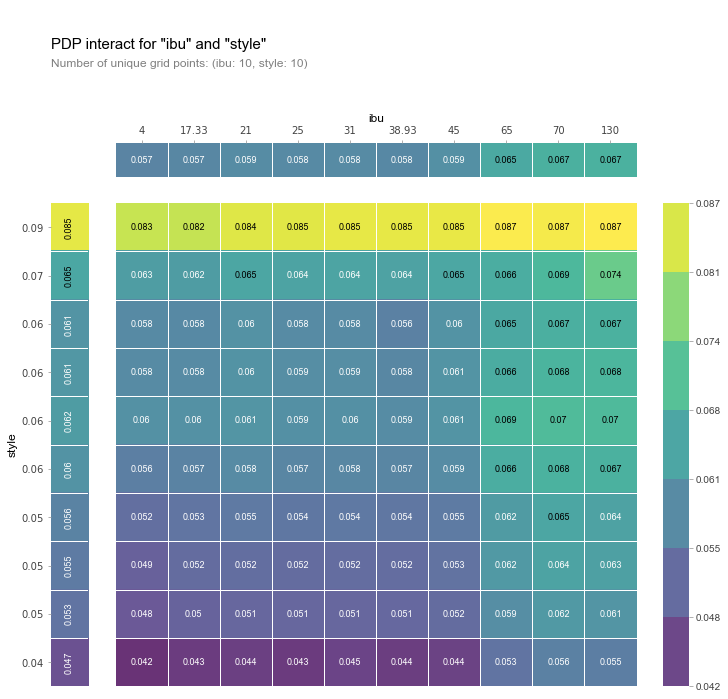

In [61]:
inter_rf = pdp.pdp_interact(
    model = pipe3[1], dataset = X_train_transformed, model_features=X_train_transformed.columns, 
    # List the name of columns you want to study here
    features=['ibu', 'style']
)

fig, axes = pdp.pdp_interact_plot(
    inter_rf, ['ibu', 'style'], x_quantile=True, plot_type='grid', plot_pdp=True
)

# XGBoost

**With XGBoost, the train score is always high even with varying parameters. 
{'train_score': 0.9830269859863368,
 'val_score': 0.5526179081575269,
 'test_score': 0.5306257244408566}**
 
 What steps are needed to "address" this? Possibly adding additonal data points such as review may help? This looks like overfitting issue. Perhap my dataset is too small and need to include additional data such as reviews, or may need to remove some columns, or dataset is inbalance. Interestly, the XGBoost train_score is very different from GradientBoost.

In [62]:
from xgboost import XGBRegressor

In [63]:
# Import two datasets
df_beer = pd.read_csv("/Users/mho/Downloads/beers.csv")
df_brewery = pd.read_csv("/Users/mho/Downloads/breweries.csv")

In [64]:
# Make name colunm in both dataframes to be more descriptive 
df_beer.rename(columns = {'name':'beer_name'}, inplace = True)
df_brewery.rename(columns = {'name':'brewery_name'}, inplace = True)

In [65]:
# Query for rows (indexes) where abv and ibu contain nulls
both_null = df_beer[ (df_beer['abv'].isnull()) & (df_beer['ibu'].isnull())].index
# Drop nulls from above cell
df_beer.drop(both_null, inplace = True)

In [66]:
# Replace nulls in stype with N/A
df_beer['style'].fillna('NA', inplace = True)

In [67]:
# Get the mean ibu based on style to even out the dataset
df_beer.groupby('style')['ibu'].mean()
#  Replace ibu null using mean of each brewery
df_beer['ibu'].fillna(df_beer.groupby('style')['ibu'].transform('mean'), inplace = True)
# Replace remaining ibu nulls with ibu mean
df_beer['ibu'].fillna(df_beer['ibu'].mean(), inplace = True)

In [68]:
# Rename unnamed column to 'brewery_id'
df_brewery.rename(columns = {'Unnamed: 0':'brewery_id'}, inplace = True)
# Drop 'Unnamed: 0' column in dataframe
df_beer.drop('Unnamed: 0', axis=1, inplace=True)
# Join beer with brewery
df = pd.merge(df_beer, df_brewery, how = 'left', on='brewery_id')

In [69]:
# helper functions to aid in the process
def split_data(df, split_frac = 0.2, random_state = 80):
    X  = df.drop('abv', axis=1)
    y  = df['abv']
    return train_test_split(X, y, test_size = split_frac, random_state = random_state)

# helper function to pull out feature importances_
def get_feature_importances(pipe, X_train, onehot=False):
    if onehot:
        X_train = pipe[0].transform(X_train).columns,
        X_train = pipe[1].transform(X_train)
    return pd.DataFrame({
        'Col': X_train.columns,
        'Importance': pipe[-1].feature_importances_
    }).sort_values(by='Importance', ascending=False)

In [70]:
# helper function to get training / validation / test scores in a single function
def get_model_scores(mod, X_train, y_train, X_test, y_test, val_score = True, test_score=False):
    if val_score:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                          test_size = 0.25, 
                                                          random_state= 80)
 
    mod.fit(X_train, y_train)
    
    results = {}
    
    results['train_score'] = mod.score(X_train, y_train)
    if val_score:
        results['val_score'] = mod.score(X_val, y_val)
        
    if test_score:
        results['test_score'] = mod.score(X_test, y_test)
        
    return results

In [71]:
# helper function to pull out feature importances_
def get_feature_importances(pipe, X_train, onehot=False):
    if onehot:
        # this section is based on the assumption that we are using a OneHotEncoder + An additional one for name
        X_train = pipe[0].transform(X_train)
        X_train = pipe[1].transform(X_train)
    return pd.DataFrame({
        'Col': X_train.columns,
        'Importance': pipe[-1].feature_importances_
    }).sort_values(by='Importance', ascending=False)

In [72]:
# split data
X_train, X_test, y_train, y_test = split_data(df)

# create pipe and get model score
te   = ce.TargetEncoder(min_samples_leaf = 10)

mod  = XGBRegressor(eval_metric = 'logloss')

pipe = make_pipeline(te, mod)

scores = get_model_scores(pipe, X_train, y_train, X_test, y_test, test_score = True)

scores

{'train_score': 0.9830269859863368,
 'val_score': 0.5526179081575269,
 'test_score': 0.5306257244408566}

In [73]:
feats = get_feature_importances(pipe, X_train)
feats

Col  Importance
3         style    0.229105
6  brewery_name    0.215385
0           ibu    0.118830
2     beer_name    0.090799
1            id    0.075185
5        ounces    0.069736
4    brewery_id    0.069135
7          city    0.068687
8         state    0.063139

In [74]:
# Get Training and Validation Scores
scores = get_model_scores(pipe, X_train, y_train, X_test, y_test, val_score = True, test_score = False)
scores

{'train_score': 0.9830269859863368, 'val_score': 0.5526179081575269}

In [75]:
# parameter search
estimators = [100, 200, 300]
max_depth  = [6, 7, 8 , 9, 10]
subsample = [0.2, 0.5] # this is the amount of samples to randomly sample in each round
cv_scores  = []

# do a training loop
for estimator in estimators:
    for depth in max_depth:
        for sample in subsample:
            print(f"Fitting new training loop for rounds: {estimator}, depth: {depth}, sampling rate: {sample}")
            pipe[-1].set_params(n_estimators = estimator, max_depth = depth, subsample = sample)
            scores = get_model_scores(pipe, X_train, y_train, X_test, y_test)
            cv_scores.append((scores['train_score'], scores['val_score'], estimator, depth, sample))

Fitting new training loop for rounds: 100, depth: 6, sampling rate: 0.2
Fitting new training loop for rounds: 100, depth: 6, sampling rate: 0.5
Fitting new training loop for rounds: 100, depth: 7, sampling rate: 0.2
Fitting new training loop for rounds: 100, depth: 7, sampling rate: 0.5
Fitting new training loop for rounds: 100, depth: 8, sampling rate: 0.2
Fitting new training loop for rounds: 100, depth: 8, sampling rate: 0.5
Fitting new training loop for rounds: 100, depth: 9, sampling rate: 0.2
Fitting new training loop for rounds: 100, depth: 9, sampling rate: 0.5
Fitting new training loop for rounds: 100, depth: 10, sampling rate: 0.2
Fitting new training loop for rounds: 100, depth: 10, sampling rate: 0.5
Fitting new training loop for rounds: 200, depth: 6, sampling rate: 0.2
Fitting new training loop for rounds: 200, depth: 6, sampling rate: 0.5
Fitting new training loop for rounds: 200, depth: 7, sampling rate: 0.2
Fitting new training loop for rounds: 200, depth: 7, sampling 

In [76]:
max(cv_scores, 
    key = lambda x: x[1])

(0.9972800806594638, 0.5242148374455009, 200, 6, 0.5)

In [77]:
# set the parameters
pipe[-1].set_params(n_estimators = 200, max_depth = 6, subsample = 0.5)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [78]:
scores = get_model_scores(pipe, X_train, y_train, X_test, y_test, val_score = False, test_score = True)

In [79]:
scores

{'train_score': 0.9936788160859809, 'test_score': 0.47653181947759893}

# Streamlit App

URL: https://share.streamlit.io/mhcode001/ga_hw4_app/main/hw4_app.py  

I ran into the following issues:
- Encountered errors with plotly during app deployment. Removed plotly.express as px and area graph to successfully deployed.
- Samples ran in "Homework 4 - Pickling.ipynb' worked, but not on app. See files under GA_HW4/app/ in GitHub
